# Bagging and random forests

Now that we're familiar with decision trees, let's explore some additional ways to find a sufficiently compled but not overfitted tree, as well as ways to make some inferences about the data.

## Goals of the lab:
* Learn how to use the `randomForest` package to apply bagging and random forests to a sample dataset
* Learn to use the `gbm` package to boost trees

Now we will apply bagging and random forests, again to the `Carseats` dataset, using the `randomForest` package.

Bagging is just a special case of a random forest with $m=p$, so the `randomForest()` function can be used for both purposes. 

In [5]:
# install.packages('randomForest') # uncomment to install package
library(randomForest)
# install.packages('ISLR')
library(ISLR) # Loading ISLR because this is where the Carseats dataset is.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [19]:
set.seed (2)
idx = 1:nrow(Carseats)
test=sample(idx, 50) #sample 50 for the test set
tune = sample(idx[-test], 150) #150 for the tuning set
train = idx[-c(test,tune)] ##select indices that are not in tune or test

bag.sales=randomForest(Sales~.,data=Carseats, subset=train, mtry=10,
                       importance=TRUE) # runs the bagging.
#the arg. mtry=11 indicates that all 11 predictors should be considered
#for each split of the tree (i.e., bagging should be done, m=p)
bag.sales


Call:
 randomForest(formula = Sales ~ ., data = Carseats, mtry = 10,      importance = TRUE, subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 10

          Mean of squared residuals: 2.992511
                    % Var explained: 62.29

Recall that "bagging" means we're fitting a decision tree to each of many permutations of our `Carseats` data set (giving us a "forest" of trees). We're then generating a prediction by taking the average of all those trees' predictions for a given observation. Let's look at the predicted values that this bagging technique generates for our test observations. 

[1] 2.345912

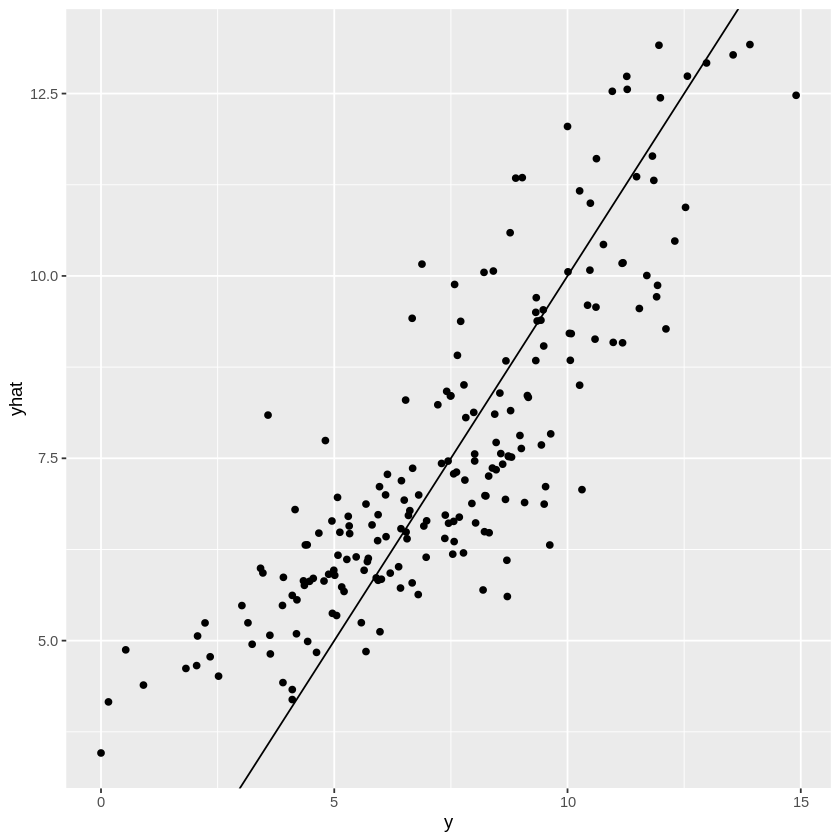

In [22]:
#test set performance of this bagged regression
sales.test = Carseats$Sales[-train]
yhat.bag = predict(bag.sales, newdata=Carseats[-train ,])
require(ggplot2)
ggplot(data.frame(yhat=yhat.bag,y=sales.test),aes(x=y,y=yhat)) + 
    geom_point() + geom_abline(slope=1,intercept=0)
mean((yhat.bag - sales.test)^2)

The test set MSE associated with the bagged regression tree is ~2.34, much lower than that obtained using an optimally-pruned single tree in the last tutorial (6.26). Also notice that the predictions are no longer "binned" like they were in the prior tutorial - again, this is because each prediction is an average across many trees' predictions, not just the output of a single tree.

We could change
the number of trees grown by randomForest() using the ntree argument:

In [26]:
set.seed(4)
bag.sales=randomForest(Sales~.,data=Carseats, subset=train, mtry=10,
                       importance=TRUE, ntree=25) #grow 25 trees
yhat.bag = predict (bag.sales,newdata=Carseats[-train ,])
mean((yhat.bag-sales.test)^2)

[1] 2.53863

Growing a random forest instead is implemented similarly. We just use a smaller value for the `mtry` argument. Note that, by default, randomForest() will use $p$/3 variables for building a random forest of regression trees, and $\sqrt p$ variables for building a random forest of classification trees.

In [27]:
set.seed(1)
rf.sales=randomForest(Sales~.,data=Carseats, subset=train ,
mtry=6, importance=TRUE)
yhat.rf = predict(rf.sales, newdata=Carseats[-train ,])
mean((yhat.rf-sales.test)^2)

[1] 2.450131

The test set MSE is ~2.45. Random forests yielded an
improvement over bagging in this case.

The `importance()` function shows the importance of each variable. 

In [29]:
importance(rf.sales)

%IncMSE   IncNodePurity
CompPrice   12.828147 142.431567   
Income       4.002538  99.699909   
Advertising 12.283050 123.400224   
Population  -4.442861  54.708305   
Price       43.961604 438.751679   
ShelveLoc   53.619274 436.628853   
Age         14.210471 147.267610   
Education    1.987748  65.338171   
Urban       -1.670795   9.161331   
US           2.076824   9.101008

This shows two metrics of importance, `%IncMSE` and `IncNodePurity` (see the James ISLR textbook, p. 330 for explanation).

You can visualize the relative importance of each variable using the below function. Here, we see that `ShelveLoc` and `Price` are the two most important predictor variables.

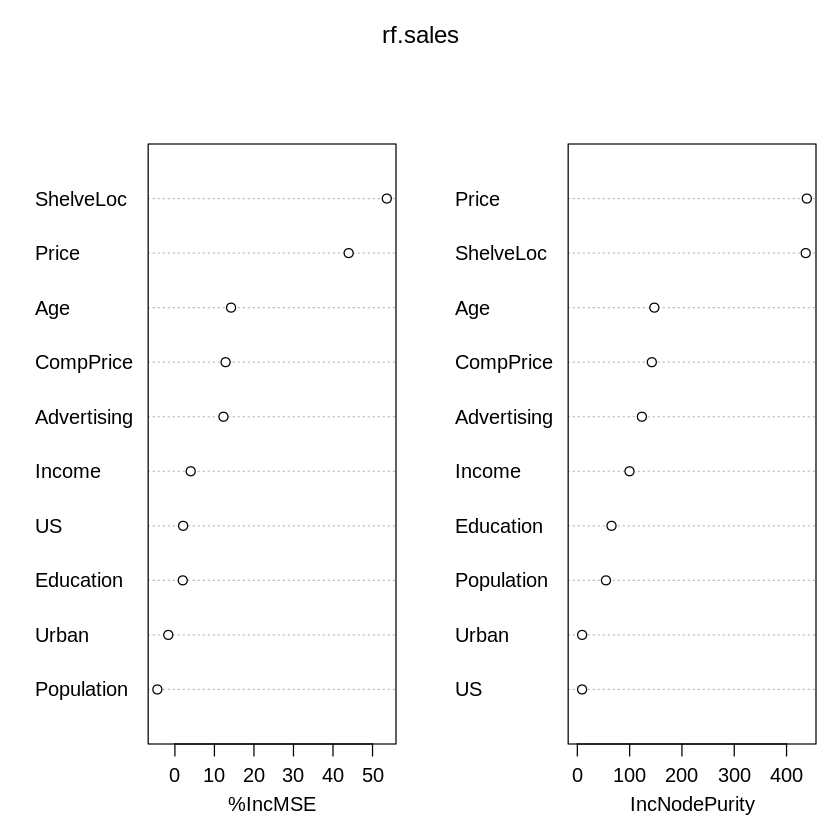

In [30]:
varImpPlot(rf.sales)

# Boosting

Here we'll use the `gbm` package and the `gbm()` function to fit boosted regression trees, still using the `Carseats` dataset.

In [32]:
# install.packages('gbm')
library(gbm)

In [33]:
set.seed (1)
boost.sales =gbm(Sales~.,data=Carseats[train ,], distribution=
                  "gaussian", n.trees=5000, interaction.depth=4)

Here, we'll use gbm() with
distribution="gaussian" because this is a regression problem. If it were binary
classification, we would use distribution="bernoulli". The
argument n.trees=5000 means that we want 5000 trees. The option
interaction.depth=4 limits the depth of each tree.

`summary()` will produce a table of relative influence statistics for each variable, and a relative influence plot.

You can see that lstat and rm are the most important variables.

See p. 331 for an extension of this called partial dependence plots. These plots show the marginal effect of selected variables on the outcome after accounting for the effect of the other variables. 

var         rel.inf   
Price       Price       26.3976801
ShelveLoc   ShelveLoc   21.7573639
CompPrice   CompPrice   13.0507087
Age         Age         10.1364627
Advertising Advertising  9.6807429
Income      Income       9.2179495
Population  Population   6.2685891
Education   Education    2.6010816
Urban       Urban        0.6003349
US          US           0.2890865

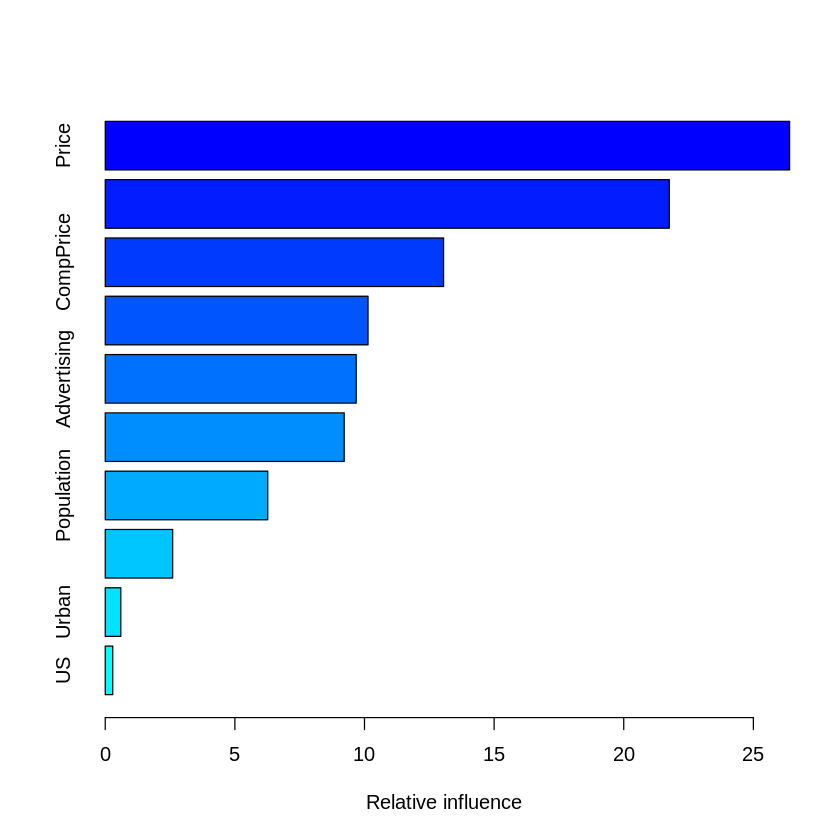

In [34]:
summary(boost.sales)

Now we'll use the boosted model to predict `Sales` in the test set. 

In [36]:
yhat.boost=predict(boost.sales,newdata=Carseats[-train ,],
n.trees=5000)
mean((yhat.boost - sales.test)^2)

[1] 2.025846

The test MSE obtained is 2.03, which is the best test MSE we've gotten yet!

*Note*: You can also construct boosted trees using a different value of the shrinkage parameter, $\lambda$, by specifying the shrinkage argument within the `gbm()` function. For example:

`boost.sales = gbm(Sales ∼.,data=Carseats[train ,], distribution=
"gaussian ",n.trees=5000 , interaction.depth=4, shrinkage=0.2,
verbose=F)`

*Notebook authored by Ven Popov and edited by Krista Bond, Charles Wu, and Patience Stevens*